# Invoice Classification From Scanned Documents

---
## 1. Project Overview

In modern financial operations, a large number of documents are processed every day. How a document can and should be processed depends on its type; therefore, identifying the document type is an important baseline step in document processing. Automating the task of identifying document types is the goal of this project, as having an algorithm that performs this task can reduce manual, repetitive labor and improve the processing time of documents.

In this project, I will address this task using Convolutional Neural Networks (CNNs) with PyTorch and train them on grayscale images of documents. The goal of these CNNs is to learn the structural layout and patterns specific to each document type and use that knowledge to distinguish between different document categories. The dataset used to train these CNNs is the [RVL-CDIP dataset](https://huggingface.co/datasets/aharley/rvl_cdip), which consists of 400,000 grayscale images of documents. The dataset includes 16 different classes, with 25,000 images per class.

Many of the classes in this dataset are not relevant to business or financial use cases; therefore, these classes will be relabeled as negative samples—i.e., samples that the model should not assign to any of the target classes. Since a large portion of the dataset includes irrelevant samples, the model must assign low confidence scores to them across all classes. To achieve this, [Entropic Open-set Loss](https://capuana.ifi.uzh.ch/publications/PDFs/22304_Master_s_Thesis_Linghu_Yu_19771682.pdf) will be used to help reject unknown samples. The dataset is split into 320,000 training images, 40,000 validation images, and 40,000 test images.

The primary goal of this project is to create a model that can take an image as input and classify its document type which a high accuracy, with a target accuracy of 90% or higher. Secondary goals include ensuring that the model is lightweight and produces outputs quickly.

Just as a note, for the rest of this notebook I will be using the words classes and label interchangably.

References: A. W. Harley, A. Ufkes, K. G. Derpanis, "Evaluation of Deep Convolutional Nets for Document Image Classification and Retrieval," in ICDAR, 2015; [study link](https://adamharley.com/icdar15/)

---
## 2. Preparing and Reviewing the Dataset

### 2.1. Loading dataset and visualizing samples from each class
First, we download the dataset and see which classes exist within the dataset. The dataset itself is quite large at about 38 GB, so please keep this in mind when deciding to run the next cell.

To visually showcase all the classes within the dataset, we create a 4 x 4 plot than showcases a sample of each classes. With this, we should be able to determine which classes(i.e document) will fit in a finance/business setting.

In [1]:
from datasets import load_dataset

ds = load_dataset("aharley/rvl_cdip", trust_remote_code=True)

Loading dataset shards:   0%|          | 0/77 [00:00<?, ?it/s]

These are the classes of the dataset: ['letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication', 'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume', 'memo']


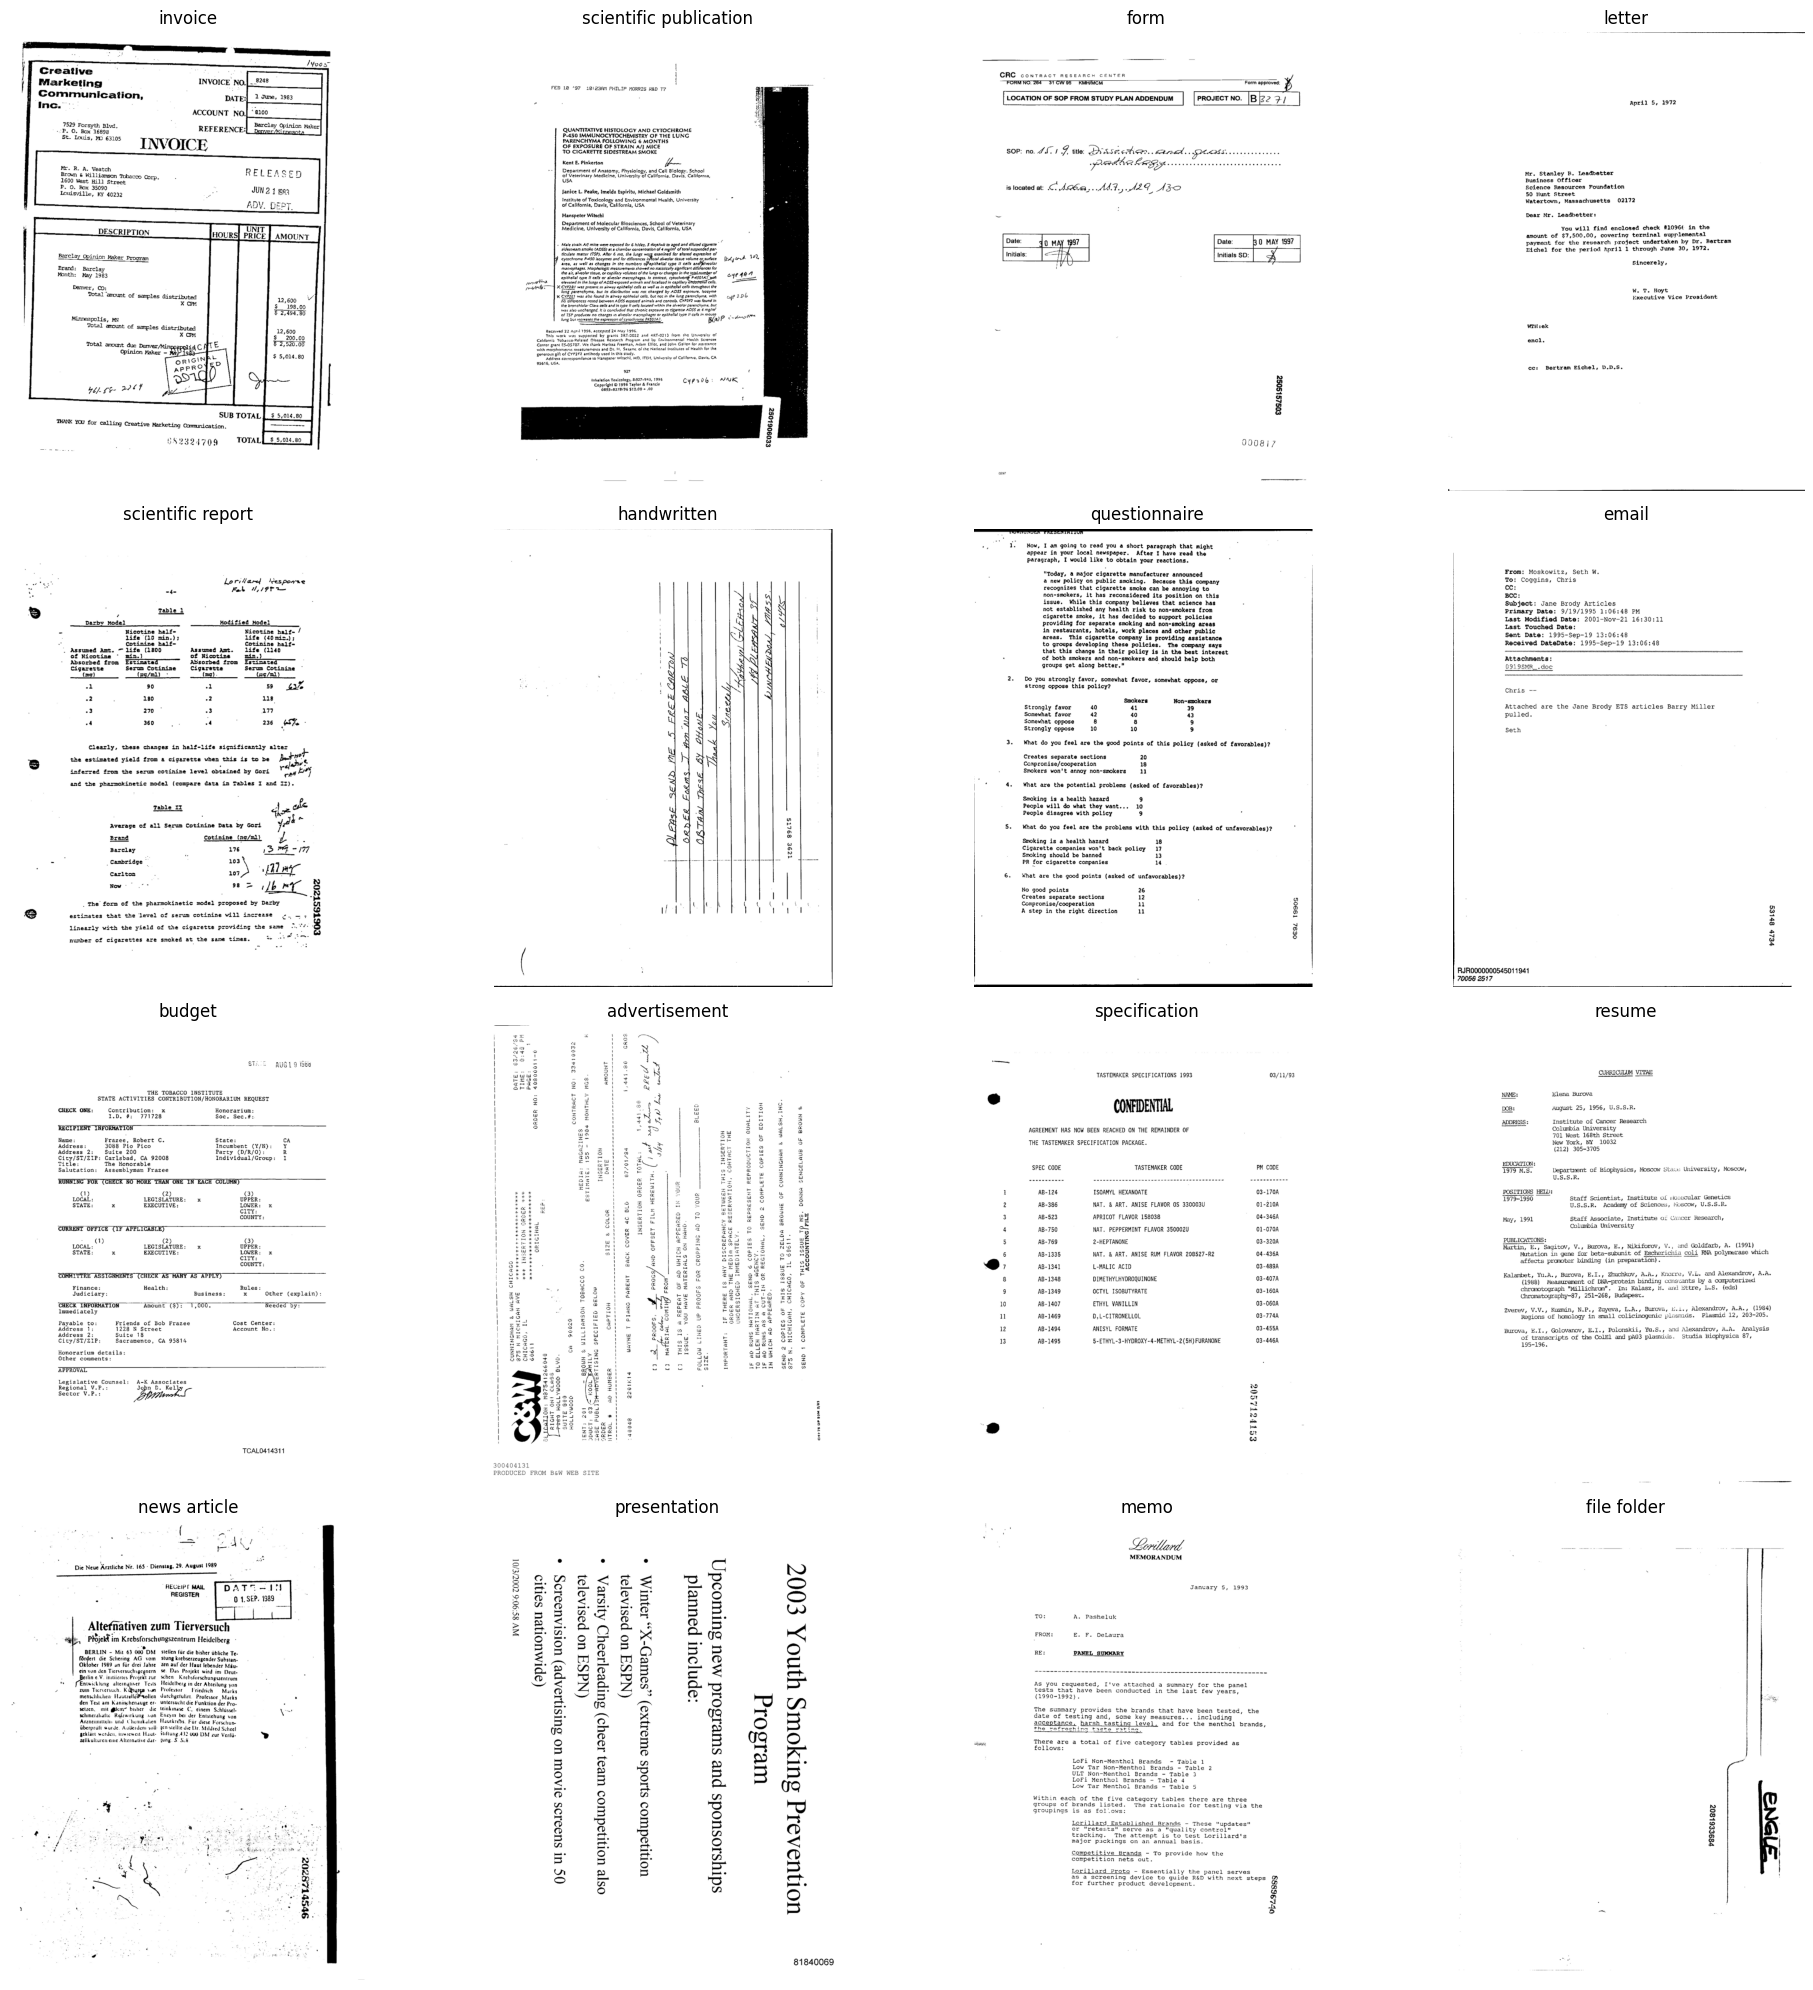

In [2]:
from matplotlib import pyplot as plt

print(f"These are the classes of the dataset: {ds['train'].features['label'].names}")

# Showcase a sample from each class
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  

classes = ds['train'].features['label'].names

seen = set()
i = 0
row = 0
col = 0
for sample in ds['train']:
    label = sample['label']
    if label not in seen:
        axes[row][col].imshow(sample['image'], cmap='gray')
        axes[row][col].set_title(f"{classes[label]}")
        axes[row][col].axis('off')
        seen.add(label)
        if row == 3:
            col += 1
            row = 0
        else:
            row += 1

    if len(seen) == 16:
        break

plt.tight_layout()
plt.show()

### 2.2. Assigning negative label to samples unrelated to business and finances

Looking at the different types of documents that present in this dataset, it is clear that some documents do not belong in a business and finance setting or are too vague to be considered. The class "Handwritten" is too vague and in modern business setting, handwritten document are usually obsolete due to documents being printed out most of the time. While news article may provide external information that can benefit a business, the paper article itself would be unlikely to be stored within the business, therefore we label it as unknown. Lastly scientific publication/report are more suited for a academic setting than a business/finance setting and will be labeled as unknown. 

The rest of the documents will keep their label and are considered documents relevant to a business/finance setting for the following reasons:
1. **email**: Used for exchange of information in businesses and financial institutions.

2. **advertisment**: A essential tool for a business and has a entire department dedicated to creating them.

3. **budget**: Important document for financial planning for companies.

4. **resume**: Relevant document for HR department.
5. **presentation**: Standard document for meeting and pitches.
6. **form**: Used for approvals for projects in businesses.
7. **specification**: Project specification, product specifications, etc.
8. **Questionnaire**: Surveys used by businesses to collect customer feedback on products/services.
9. **Invoice**: Essential for financial transactions within a business.
10. **memo**: used in internal business communication.
11. **letter**: Method for internal and external communication for a business.
12. **file folder**: While it might just be a container of documents itself, the documents within can be any of the other documents mentioned above.

In [3]:
from datasets import concatenate_datasets, ClassLabel
from PIL import Image
from io import BytesIO
from datasets import Dataset
import warnings

warnings.filterwarnings('ignore')

# All labels relevant to a business/finance setting
known_labels = [ 
    "email", 
    "advertisement", 
    "budget", 
    "resume", 
    "presentation", 
    "form", 
    "specification", 
    "questionnaire", 
    "file folder", 
    "invoice", 
    "memo", 
    "letter"
]

classes = ds['train'].features['label'].names

known_indexes = [classes.index(label) for label in known_labels]

updated_classes = ['unknown'] + known_labels
print("Known label indices:", known_indexes)
print("Updated class names:", updated_classes)

updated_labels = ClassLabel(names=updated_classes)

new_label_mapping = {original_index: new_index + 1 for new_index, original_index in enumerate(known_indexes)}

def map_to_new_label(x):
    orig_label = x['label']
    return {'label': new_label_mapping.get(orig_label, 0)}

ds = ds.map(map_to_new_label)

ds = ds.cast_column("label", updated_labels)

# From here to the end of the block corrupted images are sorted out.
# It can't be done with filter function from the library datasets, else error will be given :(
original_features = ds['train'].features

ds['test'].set_format("arrow")
raw_data = ds['test'].to_dict()

n_samples = len(raw_data['image'])

clean_samples = []

# So filtering is done manually by opening each image and verify if it is corrupted
for i in range(n_samples):
    try:
        img_bytes = raw_data['image'][i]['bytes']
        img = Image.open(BytesIO(img_bytes))
        img.verify()
        clean_samples.append({
            'image': raw_data['image'][i],
            'label': raw_data['label'][i]
        })
    except Exception as e:
        print(f"Skipping corrupted image at index {i}: {e}", end='\r')
        continue

ds['test'] = Dataset.from_list(clean_samples, features=original_features)
ds['test'].set_format("python", columns=["image", "label"])
print(ds['test'])

Known label indices: [2, 4, 10, 14, 12, 1, 7, 13, 8, 11, 15, 0]
Updated class names: ['unknown', 'email', 'advertisement', 'budget', 'resume', 'presentation', 'form', 'specification', 'questionnaire', 'file folder', 'invoice', 'memo', 'letter']
Dataset({corrupted image at index 33669: cannot identify image file <_io.BytesIO object at 0x00000148ED108C20>
    features: ['image', 'label'],
    num_rows: 39999
})


### 2.3. Class Distribution
After grouping 4 different classes together, the dataset is clearly unbalanced with the unknown class being much larger than any other class.

Number of unique classes: 13
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[99999 25000 25000 25000 25000 25000 25000 25000 25000 25000 25000 25000
 25000]


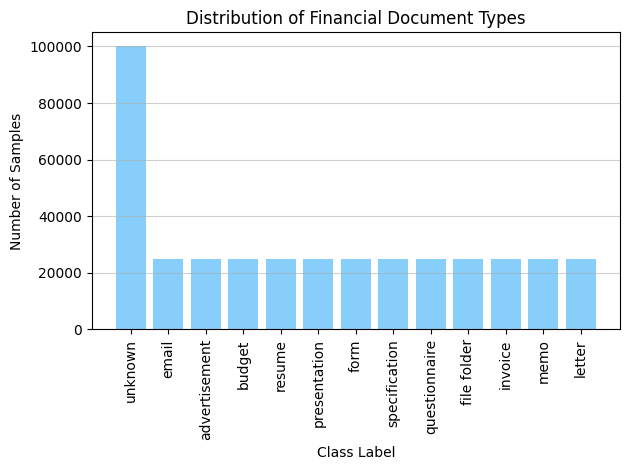

In [4]:
import numpy

def show_class_distribution(ds):
    EDA_Dataset = concatenate_datasets([ds['train'],ds['validation'],ds['test']])
    labels = EDA_Dataset['label']
    unique_labels, counts = numpy.unique(labels, return_counts=True)

    print(f"Number of unique classes: {len(unique_labels)}")
    print(unique_labels)
    print(counts)

    plt.bar(EDA_Dataset.features['label'].names, counts, width=0.8,color='#87CEFA')
    plt.xlabel('Class Label')
    plt.ylabel('Number of Samples')
    plt.title('Distribution of Financial Document Types')
    plt.xticks(unique_labels,rotation=90) 
    plt.grid(axis='y', linestyle='-', alpha=0.6)
    plt.tight_layout()
    plt.show()

show_class_distribution(ds)

### Reducing amount of unknowns
The solution to the imbalanced class distribution is to reduce the number of unknown samples by a quarter. There could be other solutions such as creating synthetic samples of the known classes until the class distribution is balanced,i.e. every class having 100.000 Samples,but this would increase the size of the complete dataset to 1.300.000 samples, which would significantly increase the model training time. The discarded unknown samples can still be used as seperate testing data to see if the model can still classify them correctly.

Number of unique classes: 13
[ 0  1  2  3  4  5  6  7  8  9 10 11 12]
[25000 25000 25000 25000 25000 25000 25000 25000 25000 25000 25000 25000
 25000]


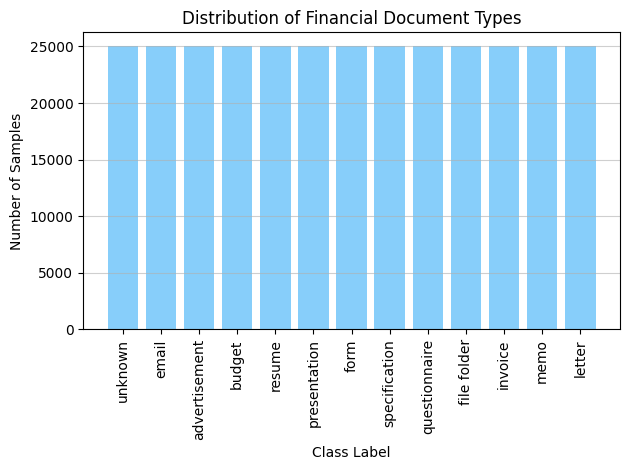

In [5]:
from datasets import DatasetDict

ds = concatenate_datasets([ds['train'],ds['validation'],ds['test']])

known_ds = ds.filter(lambda x: x["label"] != 0)
unknown_ds = ds.filter(lambda x:  x["label"] == 0)

testing_unknown_ds = unknown_ds.filter(lambda example, idx: idx % 4 != 0, with_indices=True)
unknown_ds = unknown_ds.filter(lambda example, idx: idx % 4 == 0, with_indices=True)

ds = concatenate_datasets([known_ds,unknown_ds])

train_test_ds = ds.train_test_split(test_size = 0.2)
validation_test_ds = train_test_ds["test"].train_test_split(test_size = 0.5)

ds = DatasetDict({
    'train': train_test_ds['train'],
    'test': validation_test_ds['test'],
    'validation': validation_test_ds['train']})

show_class_distribution(ds)

---
## 3. Preprocessing

### 3.1. Image Preprocessing

The image preprocessing will be keep simple, only ensuring that the images are Grayscale, resizing them to a smaller width and height(224x224), turning them into a tensor and normalizing them to help the model coverge and stay stable.

In [6]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset

if torch.cuda.is_available():
    print("Successfully enabled CUDA processing")
    device = torch.device("cuda")
else:
    print("CUDA processing not available, will use CPU instead.")
    device = torch.device("cpu")


image_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224,224)),
    transforms.ToTensor(), 
    transforms.Normalize(mean=[0.5], std=[0.5])
])

Successfully enabled CUDA processing


### 3.2. Create Custom Dataset Class

In [7]:
from PIL import Image,UnidentifiedImageError

class ScannedDocumentDataset(Dataset):
    def __init__(self, dataset, type="train", transform=None):
        self.dataset = dataset[type]
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['label']

        # At least one image was always corrupted
        # Solution: Set it to a black image with label "unknown"
        try:
            if isinstance(image, torch.Tensor):
                image = image.numpy()
            if not isinstance(image, Image.Image):
                image = Image.fromarray(image)

            if self.transform:
                image = self.transform(image)

            return image, label
        except (UnidentifiedImageError,OSError,ValueError,TypeError) as e:
            print(f"corrupted image at index: {idx}")
            void_image = torch.zeros((1,224,224))
            return void_image, 0

### 3.3 Initialize Dataloaders

In [8]:
train_ds = ScannedDocumentDataset(dataset=ds, type="train", transform=image_transforms)
val_ds = ScannedDocumentDataset(dataset=ds, type="validation", transform=image_transforms)
test_ds = ScannedDocumentDataset(dataset=ds, type="test", transform=image_transforms)

batch_size = 256

train_loader = torch.utils.data.DataLoader(train_ds,batch_size=batch_size,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_ds,batch_size=batch_size,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_ds,batch_size=batch_size,shuffle=False)

---
## 4. Model Architecture and Entropic open-set loss Function

### 4.1 Defining CNN Architecture
This CNN Architecture is largely inspired by [AlexNet](https://papers.nips.cc/paper_files/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html) and [ResNet](https://arxiv.org/abs/1512.03385). The architecture consists for a series of ```ResidualConvolutionBlock``` that always include a ```Conv2d``` with customizable kernel size, input and output chan  and a ```BatchNorm2d```, which will normalize the output of the Convolution and help the following Block with their learning. The Block also has the option to perform a ```MaxPool2d``` with a kernel of 2 and stride of 2 to reduce the feature dimensions and seperately it can perform ```Dropout2d``` that can help regularization. Finally, the a residual connection is used to append the input to the final output. If the input and output dimensions are not equal or the feature dimensions have been reduce, a appropriate skip connection is constructed to reshape the structure of the input to the dimensions of the output. Otherwise, the original input is kept untouched.

After 5 ```ResidualConvolutionBlock```, the feature space is reduced to a 1 x 1 matrix via ```AdaptiveAvgPool2d``` followed by ```flatten``` to change it to a 1d array. After 3 Fully connected Layers(i.e. ```nn.Linear```) the logits of each class is computed, which will determine the probability of each class.

In [9]:
from torch import nn
import torch.nn.functional as F

class ResidualConvolutionBlock(nn.Module):
    def __init__(self,input, output, kernel, stride_in_conv = 1, add_pool = True, add_drop = False, drop = 0.1):
        super(ResidualConvolutionBlock,self).__init__()

        padding = kernel//2

        self.conv2d = nn.Conv2d(in_channels=input,out_channels=output, kernel_size=(kernel,kernel), padding=padding, stride=stride_in_conv)
        
        self.norm = nn.BatchNorm2d(num_features=output)

        if add_pool:
            self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        else:
            self.pool = None
        
        if add_drop:
            self.dropout = nn.Dropout2d(p=drop)
        else:
            self.dropout = None

        # Residual Connection
        if stride_in_conv != 1 or input != output or self.pool is not None:
            layers = []
            # See if skip connection is required
            if input != output or stride_in_conv != 1:
                layers.extend([
                    nn.Conv2d(input, output, kernel_size=1, stride=stride_in_conv, bias=False),
                    nn.BatchNorm2d(output)
                ])
            if self.pool is not None:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            self.skip_connection = nn.Sequential(*layers)
        # Otherwise, return Identity
        else:
            self.skip_connection = nn.Identity()


    def forward(self,x):
        input = self.skip_connection(x)

        x = F.relu(self.norm(self.conv2d(x)))

        if self.dropout != None:
            x = self.dropout(x)

        if self.pool != None:
            x = self.pool(x)
            
        x = x + input
        x = F.relu(x)
        return x


class DocumentCNN(nn.Module):
    def __init__(self, K1, K2, K3, O):
        super(DocumentCNN, self).__init__()

        self.block1 = ResidualConvolutionBlock(input = 1, output=K1,kernel=7,stride_in_conv=2,add_pool=True,add_drop=True,drop = 0.1) # 224 -- stride_in_Conv = 2 & pool --> 56

        self.block2 = ResidualConvolutionBlock(input = K1, output=K2,kernel=5,stride_in_conv=2,add_pool=True,add_drop=True,drop = 0.15) # 56 -- stride_in_Conv = 2 & pool --> 14
        
        self.block3 = ResidualConvolutionBlock(input = K2, output=K3,kernel=3,stride_in_conv=1,add_pool=True,add_drop=True,drop = 0.2) # 14 -- pool --> 7

        self.block4 = ResidualConvolutionBlock(input = K3, output=K3,kernel=3,stride_in_conv=1,add_pool=False,add_drop=True,drop=0.25) # 7 --> 7

        self.block5 = ResidualConvolutionBlock(input = K3, output=K3,kernel=3,stride_in_conv=1,add_pool=False,add_drop=True,drop=0.25) # 7 --> 7

        self.avgpooling = nn.AdaptiveAvgPool2d((2, 2)) # 7 -> 2 x 2

        self.fc1 = nn.Linear(K3 *2 *2, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, O)
        self.dropout_fc = nn.Dropout(p=0.3)

    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpooling(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x)  # Should Help regularization
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        return y

### 4.2 Define Entropic Open-set Loss Function
Here the loss function is defined. The goal of [Entropic Open-Set Loss](https://capuana.ifi.uzh.ch/publications/PDFs/22304_Master_s_Thesis_Linghu_Yu_19771682.pdf) is to maximize the entropy(i.e. maximize uncertainty) of the model for unknown samples and minimize the entropy(i.e. maximize certainty) of the model for known samples. known samples will receive the standard ```cross_entropy``` function to determine the difference between predicted probability distribution and the true class distribution. For unknown samples, the loss function will try to equalize the probability of each class which will lead to uncertainty for the model as to which label is the correct one for this sample. The function to calculate the loss of the unknown samples can be found [here](https://capuana.ifi.uzh.ch/publications/PDFs/22304_Master_s_Thesis_Linghu_Yu_19771682.pdf). The mean of all losses, known and unknown, are added at the end to get the mean loss.

In [10]:
class EntropicOpenSetLoss(nn.Module):
    def __init__(self, alpha = 0.3):
        super().__init__()
        
        self.alpha = alpha

    def forward(self, logits, targets, device):
        is_known = targets != 0
        is_unknown = targets == 0

        loss_known = torch.tensor(0.0, device=device)
        loss_unknown = torch.tensor(0.0, device=device)

        loss = torch.zeros(logits.size(0), device=device)

        if is_known.any():
            loss_known = F.cross_entropy(
                logits[is_known][:, 1:], targets[is_known] - 1, reduction='mean')
        
          
        if is_unknown.any():
            logits_of_unknowns = logits[is_unknown][:, 1:] # use the known logit values from unknown samples
            unknown_probabilities_over_knowns = F.softmax(logits_of_unknowns + 1e-6, dim=1)
            entropy = -torch.sum(unknown_probabilities_over_knowns * torch.log(unknown_probabilities_over_knowns + 1e-6), dim=1)
            loss_unknown = entropy.mean()

            
        return loss_known + self.alpha * loss_unknown

---
## 5. Training, Validation and Testing Pipelines

### 5.1.1 Construct Training and validation loop

In [11]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler

def training_loop(network, train_loader, val_loader, alpha, epochs, lr, device):
    network.to(device)

    loss_func = EntropicOpenSetLoss(alpha=alpha)
    optimizer = torch.optim.AdamW(lr=lr, params=network.parameters(),weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=2)
    # Implements Automatic Mixed Precision to speed up training
    scaler = GradScaler("cuda")
    best_val_loss = 1000000
    patience = 5
    counter = 0

    for epoch in range(epochs):

        all_targets = []
        all_logits = []


        # -------------------------------------------------------------------------------------
        # Training loop
        network.train()
        train_loss, train_correct, train_total = 0, 0, 0
        for batch, (x, t) in enumerate(train_loader):
            print(f"Epoch {epoch+1}/{epochs} | Batch {batch+1}/{len(train_loader)}", end='\r')
            optimizer.zero_grad()

            x = x.to(device)
            t = t.to(device)
            with autocast("cuda",dtype=torch.float16):
                z = network(x)
                loss = loss_func(z, t, device)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()


            train_loss += loss.item()
            mask = t != 0
            if mask.any():
                train_correct += (torch.argmax(z[mask], dim=1) == t[mask]).sum().item()
                train_total += mask.sum().item()
        train_loss /= len(train_loader)
        if train_total > 0:
            train_acc = train_correct / train_total
        else:
            train_acc = 0


        # -------------------------------------------------------------------------------------
        # Validation loop
        network.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for x, t in val_loader:
                x = x.to(device)
                t = t.to(device)
                with autocast("cuda",dtype=torch.float16):
                    z = network(x)
                    loss = loss_func(z, t, device)
                val_loss += loss.item()
                mask = t != 0
                if mask.any():
                    val_correct += (torch.argmax(z[mask], dim=1) == t[mask]).sum().item()
                    val_total += mask.sum().item()
                all_logits.append(z)
                all_targets.append(t)
        val_loss /= len(val_loader)
        if val_total > 0:
            val_acc = val_correct / val_total
        else:
            val_total = 0
        scheduler.step(val_loss)


        # ------------------------------------------------------------------------------------- 


        # Training loss high and Validation loss low -> too much regularization
        # Other way around -> under-regularized / overfitting
        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        
        # -------------------------------------------------------------------------------------
        # Determine best threshold
        logits_tensor = torch.cat(all_logits, dim=0)
        labels_tensor = torch.cat(all_targets, dim=0)

        best_thresh, best_f1 = compute_best_threshold(logits_tensor, labels_tensor)
        print(f"Optimal threshold for epoch {epoch+1}: {best_thresh} | F1: {best_f1}")


        # -------------------------------------------------------------------------------------
        # Save model of current epoch if it has lower validation loss
        if val_loss < best_val_loss:
            PATH = "final_model_best_val_loss.pth"
            torch.save({
                'model_state_dict': network.state_dict(),
                'threshold': best_thresh
            }, PATH)
            best_val_loss = val_loss
            print("Model and threshold saved!")
        else:
            counter += 1
            if counter == patience:
                print("Early stopping triggered.")
                break
        

### 5.1.2 Computing best threshold

In [12]:
from sklearn.metrics import f1_score
import numpy as np

def compute_best_threshold(logits, labels):
    probs = torch.softmax(logits[:, 1:], dim=1)
    max_probs, _ = torch.max(probs, dim=1)

    max_probs = max_probs.cpu().numpy()
    labels = labels.cpu().numpy()
    binary_labels = (labels != 0).astype(int)

    thresholds = np.linspace(0.01, 0.99, 100)
    best_f1 = 0
    best_thresh = 0.5

    for thres in thresholds:
        predictions = (max_probs >= thres).astype(int)

        # F1 Score is a combination of recall and precision, 
        if (predictions == 1).sum() == 0 or (predictions == 0).sum() == 0:
            continue  
        
        f1 = f1_score(binary_labels, predictions, average="macro")

        if f1 > best_f1:
            best_f1 = f1
            best_thresh = thres

    return best_thresh, best_f1

### 5.2. Construct Test loop for network evaluation

In [13]:
def evaluate_on_testset(network, test_loader, thres, device):
    network.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0

    all_preds = []
    all_targets = []
    all_logits = []

    loss_func = EntropicOpenSetLoss()
    with torch.no_grad():
        for x, t in test_loader:
            x = x.to(device)
            t = t.to(device)
            z = network(x)
            loss = loss_func(z, t, device)
            test_loss += loss.item()

            probs = torch.softmax(z[:, 1:], dim=1)
            max_probs, pred_known = torch.max(probs, dim=1)
            threshold = thres
            prediction = torch.where(max_probs < threshold, 0, pred_known + 1)

            all_preds.append(prediction.cpu())
            all_targets.append(t.cpu())
            all_logits.append(z.cpu())

    test_loss /= len(test_loader)

    y_true = torch.cat(all_targets).numpy()
    y_pred = torch.cat(all_preds).numpy()
    y_logits = torch.cat(all_logits).numpy()

    # Compute accuracy only on known classes (label != 0)
    known_mask = y_true != 0
    test_correct = (y_pred[known_mask] == y_true[known_mask]).sum()
    test_total = known_mask.sum()
    test_acc = test_correct / test_total

    print(f"Test Loss: {test_loss:.4f}, Known-Class Accuracy: {test_acc:.4f}")

    return y_true, y_pred, y_logits

### 5.3. Run Training loop

In [15]:
import torchsummary

# Grid search would be useful with good hardware to find the best parameters
# Number of filters are rather conservative to speed up training time
K1 = 32
K2 = 64
K3 = 128
alpha = 0.3 # Originally used to help reduce the impact of unknown samples due to class distribution imbalance, might be redundant after removing excess unknown samples
lr = 0.001 
epochs = 20

print(f"Training with K1={K1}, K2={K2}, K3={K3}, lr={lr}, epochs={epochs}")
print(len(updated_classes))
assert ds['train'].features['label'].num_classes == 13
model = DocumentCNN(K1=K1, K2=K2, K3=K3, O=len(updated_classes)).to(device)
print(torchsummary.summary(model, input_size=(1, 224, 224),batch_size=256))

training_loop(model, train_loader=train_loader,val_loader=val_loader, alpha=alpha, epochs=epochs, lr=lr, device=device)

Training with K1=32, K2=64, K3=128, lr=0.001, epochs=20
13
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [256, 32, 112, 112]              32
       BatchNorm2d-2        [256, 32, 112, 112]              64
         MaxPool2d-3          [256, 32, 56, 56]               0
            Conv2d-4        [256, 32, 112, 112]           1,600
       BatchNorm2d-5        [256, 32, 112, 112]              64
         Dropout2d-6        [256, 32, 112, 112]               0
         MaxPool2d-7          [256, 32, 56, 56]               0
ResidualConvolutionBlock-8          [256, 32, 56, 56]               0
            Conv2d-9          [256, 64, 28, 28]           2,048
      BatchNorm2d-10          [256, 64, 28, 28]             128
        MaxPool2d-11          [256, 64, 14, 14]               0
           Conv2d-12          [256, 64, 28, 28]          51,264
      BatchNorm2d-13          [256, 64

### 5.3. Run Test loop

In [16]:
K1 = 32
K2 = 64
K3 = 128



model = DocumentCNN(K1=K1, K2=K2, K3=K3, O=len(updated_classes)).to(device)
saved_model = torch.load('final_model_best_val_loss.pth', map_location=device,weights_only=False)
model.load_state_dict(saved_model['model_state_dict'])
best_thresh = saved_model['threshold']

y_true, y_pred, y_logits = evaluate_on_testset(model,test_loader,best_thresh,device)

Test Loss: 0.5820, Known-Class Accuracy: 0.8417


### 5.4. Save model

---
## 6. Test Dataset evaluation

### 6.1. Evaluate known (and overall) classes metrics

In [17]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from scipy.special import softmax

known_classes = y_true != 0
y_true_known_classes = y_true[known_classes]
y_pred_known_classes = y_pred[known_classes]

print(f"Accuracy for known classes: {accuracy_score(y_true_known_classes,y_pred_known_classes)}")
print(f"Precision for known classes: {precision_score(y_true_known_classes,y_pred_known_classes,average='weighted')}")
print(f"Recall for known classes: {recall_score(y_true_known_classes,y_pred_known_classes,average='weighted', zero_division=0)}")
print(f"f1 score for known classed: {f1_score(y_true_known_classes, y_pred_known_classes,average='weighted')}",end= "\n")

overall_acc = np.mean(y_pred == y_true)
print(f"Overall Accuracy (Open Set Accuracy): {overall_acc}",end= "\n")

Accuracy for known classes: 0.8416855732016548
Precision for known classes: 0.8808187954951797
Recall for known classes: 0.8416855732016548
f1 score for known classed: 0.8598609696636369
Overall Accuracy (Open Set Accuracy): 0.7789538461538461


### 6.2. Classification Report

In [18]:
print("Classification Report for known classes:")
print(classification_report(y_true_known_classes,y_pred_known_classes, zero_division=0))

Classification Report for known classes:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.97      0.98      0.97      2478
           2       0.87      0.89      0.88      2542
           3       0.83      0.83      0.83      2590
           4       0.91      0.93      0.92      2459
           5       0.83      0.80      0.82      2476
           6       0.76      0.70      0.73      2485
           7       0.93      0.85      0.89      2467
           8       0.86      0.74      0.80      2516
           9       0.90      0.94      0.92      2442
          10       0.90      0.77      0.83      2536
          11       0.94      0.85      0.89      2532
          12       0.86      0.84      0.85      2449

    accuracy                           0.84     29972
   macro avg       0.81      0.78      0.79     29972
weighted avg       0.88      0.84      0.86     29972



### 6.3 Confusion Matrix

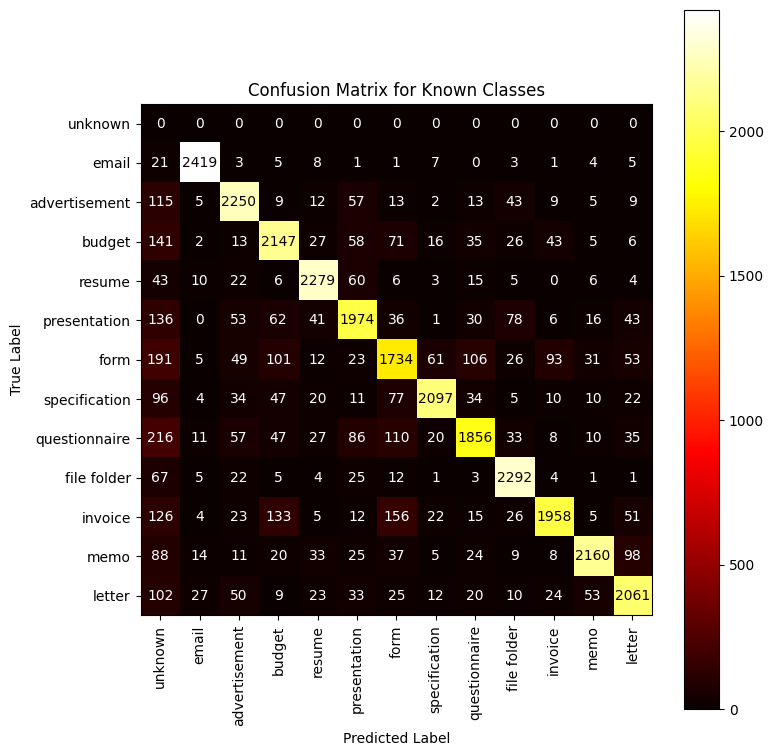

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

known_class_matrix = confusion_matrix(y_true_known_classes, y_pred_known_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=known_class_matrix,display_labels=ds['train'].features['label'].names)


fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap=plt.cm.hot, ax=ax)
plt.setp(ax.get_xticklabels(), rotation=90)
plt.title('Confusion Matrix for Known Classes')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


---
## 7. Conclusion